[31, 78, 198, 40, 252, 204, 203, 71, 48, 217]
[191, 193, 178, 59, 131, 243, 29, 38, 112, 64]
(8256, 3)
[[101 144 245]
 [231 234 465]
 [179 169 348]
 [ 31 229 260]
 [ 27 125 152]
 [ 95  70 165]
 [ 37 121 158]
 [ 87  88 175]
 [216   4 220]
 [ 65 195 260]]


(8256, 16)
[[0 1 1 0 0 1 0 1 1 0 0 1 0 0 0 0]
 [1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0]
 [1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 1]
 [0 0 0 1 1 1 1 1 1 1 1 0 0 1 0 1]
 [0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 1]
 [0 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0]
 [0 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1]
 [0 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0]
 [1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1]] 

(8256, 9)
[[0 1 1 1 1 0 1 0 1]
 [1 1 1 0 1 0 0 0 1]
 [1 0 1 0 1 1 1 0 0]
 [1 0 0 0 0 0 1 0 0]
 [0 1 0 0 1 1 0 0 0]
 [0 1 0 1 0 0 1 0 1]
 [0 1 0 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 1 1]
 [0 1 1 0 1 1 1 0 0]
 [1 0 0 0 0 0 1 0 0]]


(7431, 16)
(825, 16)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape       

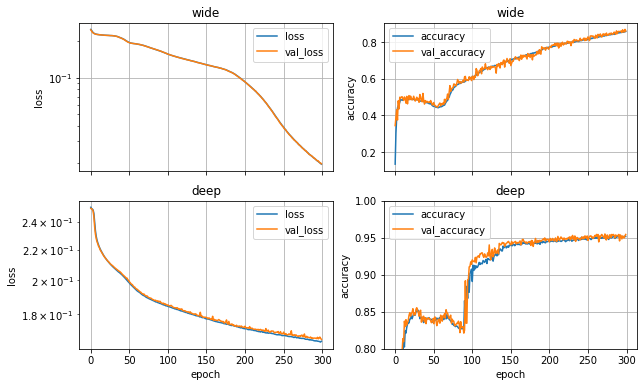

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def int2bin(d, n_bits):
    """Convert integer to binary number having fixed number of difits n_bits"""
    b = bin(d)[2:]  # remove prefix '0b'
    add_zeros = n_bits - len(b)
    if add_zeros > 0:
        b = add_zeros * '0' + b
    return b

def int2list(d, n_bits):
    """Converts integer to list of binary numbers that correspond to its binary representation"""
    s = int2bin(d, n_bits)
    return [int(x) for x in s]

def get_values(N, n_bits, rng):
    """Generate random list of numbers"""
    nums = list(range(2**n_bits))
    rng.shuffle(nums)
    return nums[:N]

rng = np.random.default_rng()

# create a set of pairs of integers and their sums
N = 128
n_bits = 8

values1 = get_values(N, n_bits, rng)
values2 = get_values(N, n_bits, rng)
print(values1[:10])
print(values2[:10])

data_orig = []
for i in range(N):
    for j in range(i, N):
        a = values1[i]
        b = values2[j]
        data_orig.append([a, b, a + b])
rng.shuffle(data_orig)
data_orig = np.array(data_orig)

print(data_orig.shape)
print(data_orig[:10])
print('\n')

# the integers and their sums are converted to the binary form
X_data = []
Y_data = []
for abc in data_orig:
    a, b, c = abc
    X_data.append(int2list(a, n_bits) + int2list(b, n_bits))
    Y_data.append(int2list(c, n_bits + 1))

X_data = np.array(X_data)
Y_data = np.array(Y_data)

print(X_data.shape)
print(X_data[:10], "\n")
print(Y_data.shape)
print(Y_data[:10])
print('\n')

# split the dataset into training and testing parts
p_test = 0.1
n_test = int(p_test * len(X_data))
X_train = X_data[:-n_test]
Y_train = Y_data[:-n_test]

X_test = X_data[-n_test:]
Y_test = Y_data[-n_test:]

print(X_train.shape)
print(X_test.shape)
print('\n')

epochs = 300
validation_split = 0.2
learning_rate = 1e-3

activation = tf.keras.activations.hard_sigmoid

# wide model
model_wide = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10*n_bits, activation=activation),
  tf.keras.layers.Dense(n_bits+1, activation=activation)
])

loss = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_wide.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

model_wide.evaluate(X_train, Y_train, verbose=0)
model_wide.summary()

# train wide model
hist_wide = model_wide.fit(X_train, Y_train, epochs=epochs,
                           verbose=2, validation_split=validation_split)

# test wide model
model_wide.evaluate(X_test, Y_test)

# deep model
model_deep = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2*n_bits, activation=activation),
  tf.keras.layers.Dense(n_bits+1, activation=activation),
  tf.keras.layers.Dense(n_bits+1, activation=activation),
  tf.keras.layers.Dense(n_bits+1, activation=activation)
])

loss = tf.keras.losses.MeanSquaredError()
optim = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_deep.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

model_deep.evaluate(X_train, Y_train, verbose=0)
model_deep.summary()

# train deep model
hist_deep = model_deep.fit(X_train, Y_train, epochs=epochs,
                           verbose=2, validation_split=validation_split)

# test deep model
model_deep.evaluate(X_test, Y_test)


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True)
fig.patch.set_facecolor('white')

ax = axs[0,0]
ax.plot(range(epochs), hist_wide.history['loss'], label='loss')
ax.plot(range(epochs), hist_wide.history['val_loss'], label='val_loss')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('wide')

ax = axs[0,1]
ax.plot(range(epochs), hist_wide.history['accuracy'], label='accuracy');
ax.plot(range(epochs), hist_wide.history['val_accuracy'], label='val_accuracy');
ax.set_ylabel('accuracy')
ax.set_title('wide')

ax = axs[1,0]
ax.plot(range(epochs), hist_deep.history['loss'], label='loss')
ax.plot(range(epochs), hist_deep.history['val_loss'], label='val_loss')
ax.set_ylabel('loss')
ax.set_yscale('log')
ax.set_title('deep')

ax = axs[1,1]
ax.plot(range(epochs), hist_deep.history['accuracy'], label='accuracy');
ax.plot(range(epochs), hist_deep.history['val_accuracy'], label='val_accuracy');
ax.set_ylabel('accuracy')
ax.set_ylim([0.8, 1])
ax.set_title('deep')

for ax in axs.ravel():
    ax.grid()
    ax.legend()

axs[1,0].set_xlabel('epoch')
axs[1,1].set_xlabel('epoch');

In [3]:
def tens_rec(res, bits):
    res_rec = [np.empty(bits+1, dtype=int)]
    for q in res:
        for p in range(0, res.shape[1]):
            if q[p] >= 0.5:
                res_rec[0][p] = 1
            else:
                res_rec[0][p] = 0
    res_rec = np.array(res_rec).flatten()
    res_rec = res_rec.tolist()
    res_rec = ''.join(map(str, res_rec))
    res_rec = int(res_rec, 2)
    return res_rec

# n1 = 15
# n2 = 25

n1 = int(input('Please enter the first number (must be below 256)'))
n2 = int(input('Please enter the second number (must be below 256)'))

values = [[n1, n2]]
values = np.array(values)

v_conv = [int2list(n1, n_bits) + int2list(n2, n_bits)]

v_conv = np.array(v_conv)

# print(v_conv)

pred_wide = model_wide(v_conv, training=False)
# print(pred_wide)

pred_deep = model_deep(v_conv, training=False)
# print(pred_deep)

pred_wide_int = tens_rec(pred_wide, n_bits)
pred_deep_int = tens_rec(pred_deep, n_bits)

print(pred_wide_int)
print(pred_deep_int)

if pred_wide_int == n1+n2:
    print('The wide model predicted a correct answer')
else:
    print('The wide model predicted an incorrect answer')

if pred_deep_int == n1+n2:
    print('The deep model predicted a correct answer')
else:
    print('The deep model predicted an incorrect answer')


40
126
The wide model predicted a correct answer
The deep model predicted an incorrect answer
